# Self-Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import glob
import os
from imageio import imwrite
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Camera Calibration

Determine the calibration matrix and distortion coefficients of the camera used in this project, using chessboard photos taken by it

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
img_size = (1280, 720)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## Image Processing Pipeline
### I/O Utilities

In [3]:
load_path = 'test_images'
save_path = 'output_images'

def save_img(old_path, prefix, img):
    path = os.path.join(save_path, prefix + '_' + os.path.basename(old_path))
    out = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else img
    imwrite(path, out)
    
def visualize(img, img_processed, img_text, img_processed_text):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title(img_text, fontsize=18)
    ax2.imshow(cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB))
    ax2.set_title(img_processed_text, fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Remove distortion

In [4]:
# Remove distortion from images
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

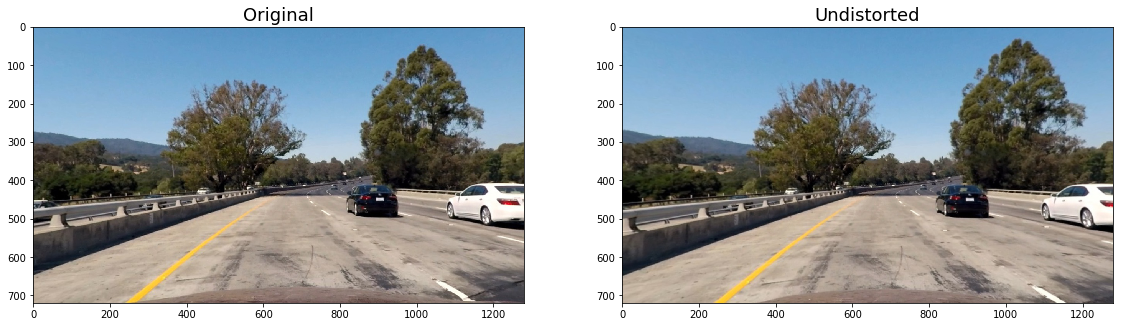

In [5]:
images = glob.glob(os.path.join(load_path, 'test*.jpg'))
for image in images[0:1]:
    img = cv2.imread(image)
    undist = undistort(img)
    save_img(image, "undistorted", undist)
    visualize(img, undist, "Original", "Undistorted")

### Perspective Transform

In [6]:
# Perform perspective transform to get an 'bird-eye' view of the road
def transform_perspective(undist):
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, Minv

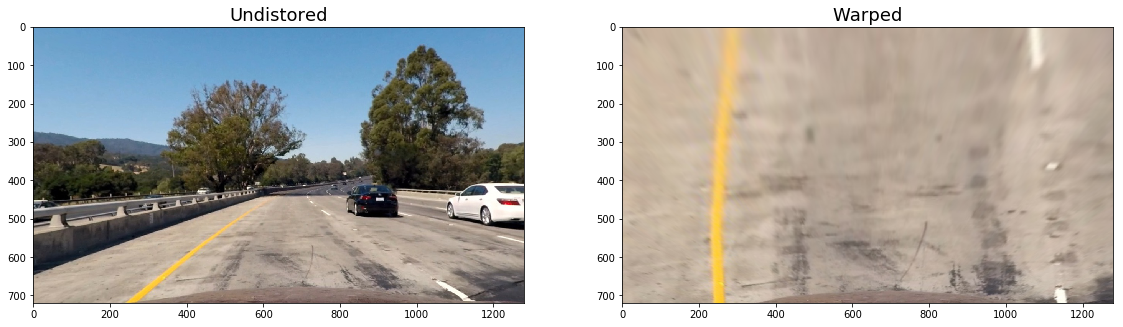

In [7]:
images = glob.glob(os.path.join(load_path, 'test*.jpg'))
for image in images[0:1]:
    img = cv2.imread(image)
    undist = undistort(img)
    warped = transform_perspective(undist)[0]
    save_img(image, "warped", warped)
    visualize(img, warped, "Undistored", "Warped")

### Color Channel Thresholds

In [8]:
# Create binary thresholded images to reveal lane line pixels
def apply_thresholds(b_channel, l_channel):
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return combined_binary

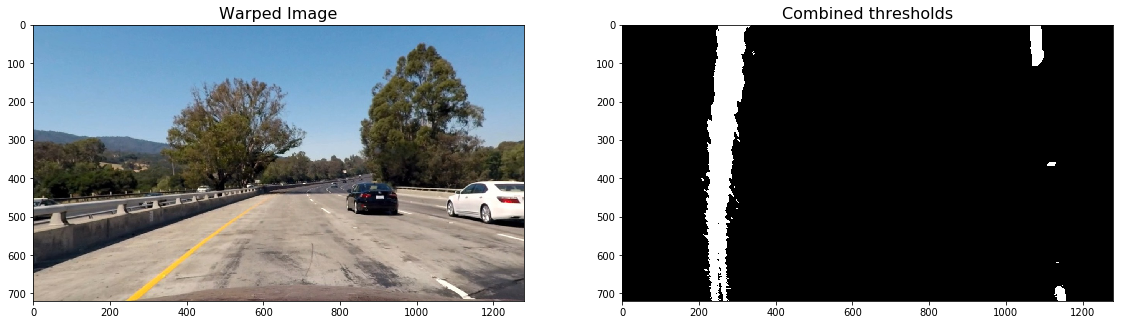

In [9]:
images = glob.glob(os.path.join(load_path, 'test*.jpg'))
for image in images[0:1]:
    img = cv2.imread(image)
    undist = undistort(img)
    warped = transform_perspective(undist)[0]
    b_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2Lab)[:,:,2]   
    l_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2LUV)[:,:,0]
    combined_binary = apply_thresholds(b_channel, l_channel)
    save_img(image, "thresholded", combined_binary)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.set_title('Warped Image', fontsize=16)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
    ax2.set_title('Combined thresholds', fontsize=16)
    ax2.imshow(combined_binary, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Fitting a polynomial to the lane lines, calculating the vehicle position and the road's radius of curvature:

#### Line
Added the Line object to keep track of relavant attributes of lane lines between frame 

In [10]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    # Use when lane lines are detected in the previous frame
    def found_search(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x) & (x < (xval + 25)) & ((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    # Search for the lane lines from scratch
    def blind_search(self, x, y, image):
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x) & (x < (peak + 25)) & ((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals)*ym_per_pix + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

#### Drawing lanes
Filling the lane area, calculating the car position and the road curvature

In [11]:
def fill_lane(undist, combined_binary, Minv):
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)
            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, img_size[0])
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int + leftx_int) / 2
    distance_from_center = (position - 640) * 3.7 / 700 
                    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1]))
    lane_filled = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    # Print distance from center on video
    cv2.putText(lane_filled, 'Distance from the road center: {:.2f} m'.format(distance_from_center), (100,80),
                fontFace = 16, fontScale = 0.8, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(lane_filled, 'Radius of Curvature: {} m'.format(int((Left.radius + Right.radius)/2)), (120,140),
                fontFace = 16, fontScale = 0.8, color=(255,255,255), thickness = 2)
    Left.count += 1
    
    return lane_filled

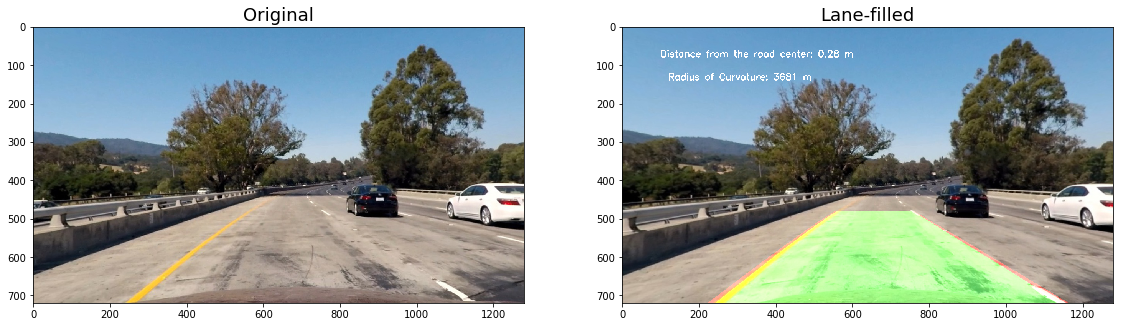

In [12]:
images = glob.glob(os.path.join(load_path, 'test*.jpg'))
for image in images[0:1]:
    img = cv2.imread(image)
    undist = undistort(img)
    warped, Minv = transform_perspective(undist)
    b_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2Lab)[:,:,2]   
    l_channel = cv2.cvtColor(warped, cv2.COLOR_BGR2LUV)[:,:,0]
    combined_binary = apply_thresholds(b_channel, l_channel)
    Left = Line()
    Right = Line()
    lane_filled = fill_lane(undist, combined_binary, Minv)
    save_img(image, "lane-filled", lane_filled)
    visualize(img, lane_filled, "Original", "Lane-filled")

## Video Processing Pipeline:
Putting together the pipeline to process each image to form the video processing pipeline

In [13]:
# Video Processing Pipeline
def process_vid(image):
    undist = undistort(image)  
    warped, Minv = transform_perspective(undist)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    combined_binary = apply_thresholds(b_channel, l_channel)
    
    lane_filled = fill_lane(undist, combined_binary, Minv)
    return lane_filled

In [14]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2) # to produce the full-length video, remove 'subsclip' method
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:09<00:00,  4.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



Here is the result on the project video

In [15]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [16]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:34<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



Following is the result on the challenge video

In [17]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))

## Discussion

One of the big challenge is to incorporate the detection of lane lines in previous frame to speed up the search for lane lines in the current frame. The solution is to use an Line object to keep tract of lane line attributes in the previous frame. Even though the current pipeline works decently on the challenge clip (but not perfectly, especially when there is car on the adjacent lane), it performs suboptimally on the harder challenge clip. This could be because the current pipeline doesn't take into account the confidence level of the polynomial fitting. In other words, as long as some lane lines are found, it will use them as the baseline for the detection in the next frame. Thus, it may be better if the pipline ignore fitting with low confidence. Furthermore, if the Line class can store lane lines further back in the video, we can use the moving average of relevant attributes to reject outlier.